In [ ]:
conda env export > environment.yml

In [1]:
import os
import re, string, unicodedata
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')

In [2]:
import inflect
from spellchecker import SpellChecker
import csv

In [93]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize.stanford_segmenter import StanfordSegmenter

In [103]:
# import dataset
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Text(0.5, 1.0, 'Binary Distribution of Disaster Tweet Dataset')

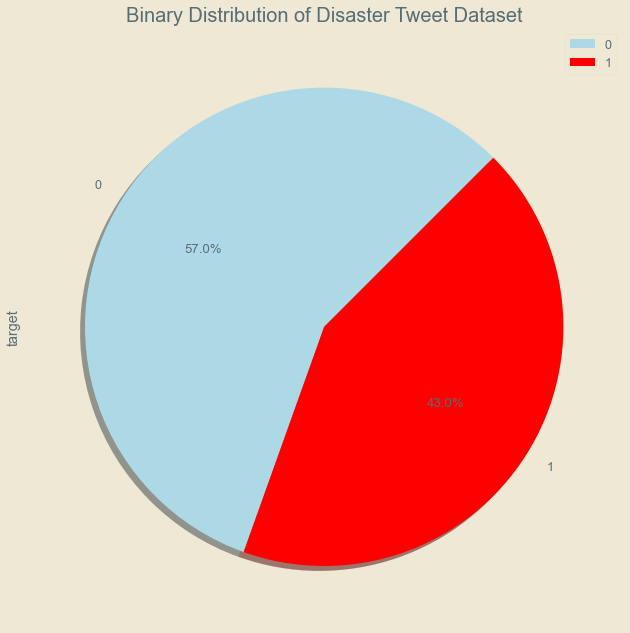

In [5]:
# visualize distribution of target in dataset
plt.figure(figsize=(11,11))
colors = ['lightblue', 'red']
expl = (0, 0.1)
df.target.value_counts().plot(kind='pie', legend=True, startangle=45, shadow=True, 
                             colors=colors, autopct='%1.1f%%')
plt.title('Binary Distribution of Disaster Tweet Dataset', fontsize=20)

In [6]:
# import and read previously created dictionary as csv for abbreviations and expansions of words
def csv2dict(csv_name):
    with open(csv_name, mode='r') as f:
        reader = csv.reader(f)
        next(reader)
        return {rows[1]:rows[2] for rows in reader}

In [151]:
location_expansion_dict = csv2dict('location_expansion.csv')
word_expansion_dict = csv2dict('word_expansions.csv')



    def proper_nouns_lower(text): 
        text = re.sub('#', ' ', text)
        proper_noun = re.match(r"(?<=[A-Z])[a-z]", text)
        if text is proper_noun:
            new_string = re.sub(proper_noun, proper_noun.group(0).lower(), text)
        else:
            new_string = text
        return new_string
        
        
    def word_expansion(text):
        c_re = re.compile('|'.join('(\b%s\b)' % re.escape(s) for s in word_expansion_dict.keys()), re.IGNORECASE)
        def replace(match):
            expansion =  f" {word_expansion_dict[match.group(0)]}"
            return expansion
        text = c_re.sub(replace, text.lower())
        return text


In [104]:
def expand_hashtags(text):
    hashtag_list = []
    hashtag_exp_list = []

    def camel_case_split(text):
        text = re.sub('#', ' ', text)
        # regex to insert space before uppercase letter when not at start of line using pos.lookahead and pos.lookbehind
        exp_hashtags = re.sub(r'((?<!\A)(?<=[a-z])[A-Z]|(?<!\A)(?=[A-Z])[a-z+])', r' \1', text)
        return exp_hashtags
        
    def denoise_hashtag_text(text):
        new_text = re.sub(r"\S*https?:\S*",  r"", text)
        new_text_punct = re.sub(r"[^\w\s#]",  r"", new_text)
        new_text_chars = re.sub('[^\u0000-\u007f]', '',  new_text_punct)
        new_text_ = re.sub('_', '',  new_text_chars)
        return new_text_
    
    def replace_numbers(tokens):
        dig2word = inflect.engine()
        new_tokens = []
        for word in tokens:
            if word.isdigit():
                new_word = dig2word.number_to_words(word)
                new_tokens.append(new_word)
            else:
                new_tokens.append(word)
        return new_tokens
    
    for tweet in text:
        for x in tweet.split():
            if x.startswith('#') == True:
                clean_text = denoise_hashtag_text(x)
                cleaner_text = replace_numbers(clean_text)
                hashtag_list.append(''.join(cleaner_text))
                
    for hashtag in hashtag_list: 
        exp_hashtag = camel_case_split(hashtag)
        strip_hash = exp_hashtag.strip()
        hashtag_exp_list.append(strip_hash)
        
    return dict(zip(hashtag_list, hashtag_exp_list))

In [9]:
loc_hashtags_dict = expand_hashtags(df.location.astype(str))
hashtags_dict = expand_hashtags(df.text)

In [10]:
test_loc_hashtags_dict = expand_hashtags(test_df.location.astype(str))
test_hashtags_dict = expand_hashtags(test_df.text)

In [141]:
def expand_words(df, hashtag_dict, expansion_dict):
    
    def camel_sub(text):
        cam_re = re.compile(r'(\b%s\b)' % '|'.join(hashtag_dict.keys()))
        def replace(match):
            expansion =  f" {hashtag_dict[match.group(0)]}"
            return expansion
        text = cam_re.sub(replace, text)
        return text
    
    def word_expansion(text):
        c_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
        def replace(match):
            expansion =  f"{expansion_dict[match.group(0)]}"
            return expansion
        text = c_re.sub(replace, text.lower())
        return text
    
    text = camel_sub(df)
    expanded_text = word_expansion(text)
    return expanded_text

In [142]:
def remove_non_ascii(tokens):
        new_tokens = []
        for word in tokens:
            new_token = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_tokens.append(new_token)
        return new_tokens

In [143]:
def cap_location_exp(text, expansion_dict=location_expansion_dict):
        lt_re = re.compile(r'\b'+r'\b|\b'.join(expansion_dict.keys())+r'\b')
        def replace(match):
            expansion =  f"{expansion_dict[match.group(0)]}"
            return expansion
        text = lt_re.sub(replace, text)

In [144]:
lt_re = re.compile(r'\b'+r'\b|\b'.join(location_expansion_dict.keys())+r'\b')
lt_re

re.compile(r'\bAK\b|\bAL\b|\bAR\b|\bAZ\b|\bCA\b|\bCO\b|\bCT\b|\bDC\b|\bFL\b|\bGA\b|\bGU\b|\bHI\b|\bIA\b|\bID\b|\bIL\b|\bKS\b|\bKY\b|\bLA\b|\bMA\b|\bMD\b|\bMI\b|\bMN\b|\bMO\b|\bMP\b|\bMS\b|\bMT\b|\bNC\b|\bND\b|\bNE\b|\bNH\b|\bNJ\b|\bNM\b|\bNV\b|\bNY\b|\bOH\b|\bOK\b|\bPA\b|\bPR\b|\bPW\b|\bRI\b|\bSC\b|\bSD\b|\bTN\b|\bTX\b|\bUT\b|\bVA\b|\bVI\b|\bVT\b|\bWA\b|\bWI\b|\bWV\b|\bWY\b|\bAB\b|\bBC\b|\bMB\b|\bNB\b|\bNL\b|\bNS\b|\bNT\b|\bNU\b|\bON\b|\bPE\b|\bQC\b|\bSK\b|\bYT\b|\bUK\b',
re.UNICODE)

In [152]:
#### text preprocessing specifically formatted for tweets but will work on any text
def tweet_preprocess(df): 
    """combine regex and nltk processing for tweet text processing"""
    
    # function to replace state abbreviations only when capitalized as in dictionary input to avoid replacing words
    # states ME, IN, DE excluded due to possibility of common use in 'screaming' tweets
    def cap_location_exp(text, expansion_dict=location_expansion_dict):
        lt_re = re.compile(r'\b'+r'\b|\b'.join(expansion_dict.keys())+r'\b')
        def replace(match):
            expansion =  f"{expansion_dict[match.group(0)]}"
            return expansion
        text = lt_re.sub(replace, text)
        return text
    # function to split camelcase occurences in hashtags 
    def camel_case_split(text):
        if text.startswith('#'):
            new_text = re.sub(r'((?<!\A)(?<=[a-z])[A-Z]|(?<!\A)(?=[A-Z])[a-z+])', r' \1', text)
        else:
            new_text = text
        return new_text
    
    #function to replace contractions and abbreviated words such as 'wtf', performed on lowercased text
    def word_expansion(text, expansion_dict=word_expansion_dict):
        e_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
        def replace(match):
            expansion =  f"{expansion_dict[match.group(0)]}"
            return expansion
        text = e_re.sub(replace, text.lower())
        return text
    
    # function to remove urls, NaN string, non-unicode characters
    def denoise_tweet(text):
        new_text = re.sub(r"\S*https?:\S*",  r"", text)
        nan_text = re.sub('nan', '', new_text)
        new_text_punct = re.sub(r"[^\w\s@]",  r" ", nan_text)
        text_digit = re.sub(r"((?<!\A)(?<=[\d])[\w]|(?<!\A)(?<=[\w])[\d])",  r" ", new_text_punct)
        km_text = re.sub('km', 'kilometers', text_digit)
        unicode_chars = re.sub('[^\u0000-\u007f]', ' ', km_text)
        return unicode_chars.strip()
    
# tokenization & lemmatization function returns tokens    
    def lemmatize_text(text):
        tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
        lemmatizer = WordNetLemmatizer() 
        return [lemmatizer.lemmatize(w, pos='v') for w in tokenizer.tokenize(text)]

    def replace_numbers(tokens):
        dig2word = inflect.engine()
        new_tokens = []
        for word in tokens:
            if word.isdigit():
                new_word = dig2word.number_to_words(word)
                new_tokens.append(new_word)
            else:
                new_tokens.append(word)
        return new_tokens
    
    def remove_non_ascii(tokens):
        new_tokens = []
        for word in tokens:
            new_token = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_tokens.append(new_token)
        return new_tokens
      
    def remove_stopwords(tokens):
        stop_list = stopwords.words('english')  
        new_tokens = []
        for word in tokens:
            if word not in stop_list:
                new_tokens.append(word)
        return new_tokens
    
    def norm_text(tokens):
        words = replace_numbers(tokens)
        new_words = remove_stopwords(words)
        newer_words = remove_non_ascii(new_words)
        return newer_words
    
    def process_text(text):
        exp_loc_tweet = cap_location_exp(text)
        split_hash = camel_case_split(exp_loc_tweet)
        exp_text = word_expansion(split_hash)
        clean_text = denoise_tweet(exp_text)
        lem_text = lemmatize_text(clean_text)
        text = ' '.join([x for x in norm_text(lem_text) if len(x)>1])
        new_text = re.sub(r"-",  r" ", text)
        newer_text = re.sub(r'nan',  r"", new_text)
        exp_text = expand_words(newer_text, loc_hashtags_dict, location_expansion_dict)
        return text
    
    new_df = [process_text(x) for x in df]

    return new_df 

In [153]:
df['tweets'] = tweet_preprocess(df.text)
df['keyword'] = tweet_preprocess(df.keyword.astype(str).replace({r"%20" : r" "}, regex=True))

In [154]:
test_df['tweets'] = tweet_preprocess(test_df.text)
test_df['keyword'] = tweet_preprocess(test_df.keyword.astype(str).replace({r"%20" : r" "}, regex=True))

In [155]:
df

,id,keyword,location,text,target,tweets
0,1,,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,,NaN,All residents asked to 'shelter in place' are ...,1,residents ask shelter place notify officer eva...
3,6,,NaN,"13,000 people receive #wildfires evacuation or...",1,one zero people receive wildfires evacuation o...
4,7,,NaN,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...
7608,10869,,NaN,Two giant cranes holding a bridge collapse int...,1,two giant crane hold bridge collapse nearby home
7609,10870,,NaN,@aria_ahrary @TheTawniest The out of control w...,1,control wild fire california even northern par...
7610,10871,,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,nine zero zero utc five volcano hawaii
7611,10872,,NaN,Police investigating after an e-bike collided ...,1,police investigate bike collide car little por...


In [49]:
def preprocess_location(df):

    def lemmatize_loc_text(text):
        tokenizer = TweetTokenizer(strip_handles=True)
        lemmatizer = WordNetLemmatizer() 
        return [lemmatizer.lemmatize(w, pos='n') for w in tokenizer.tokenize(text)]
    
    def norm_loc_text(tokens):
        words = remove_non_ascii(tokens)
        return words
    
    def denoise_location_text(text):
        text = str(text)
        exp_text = expand_words(text, loc_hashtags_dict, location_expansion_dict)
        non_url_str = re.sub(r"\S*https?:\S*",  r"", exp_text.lower())
        alpha_str = re.sub(r"[^a-zA-Z]",  r" ", non_url_str)
        clean_text = re.sub(r'nan',  r"", alpha_str)
        unicode_string = re.sub('[^\u0000-\u007f]', '',  clean_text)
        lem_text = lemmatize_loc_text(unicode_string)
        new_text = ' '.join([x for x in norm_loc_text(lem_text) if len(x)>1])
        new_text = re.sub(r"est",  r"", new_text)
        return new_text

    
    new_df = [denoise_location_text(x) for x in df]
    return new_df 



In [50]:
df['clean_location'] = preprocess_location(df.location)

In [51]:
test_df['clean_location'] = preprocess_location(test_df.location)

In [52]:
def combine_columns(df):
    df['keyword'] = df.keyword.astype(str)
    df['keyword'] = df.keyword.str.lower()
    df['keyword'] = df.keyword.str.replace(r'nan', r'')
    df['clean_location'] = df.clean_location.astype(str)
    df['clean_location'] = df.clean_location.str.lower()
    df['clean_location'] = df.clean_location.str.replace(r'nan', r'')
    df['tweets'] = df.tweets.astype(str)
    df['all_text'] = df['tweets'].str.cat(df['clean_location'],sep=" ")
    df['all_text'] = df['all_text'].str.cat(df['keyword'],sep=" ")
    df['all_text'] = df['all_text'].str.strip()
    df['combined_tokens'] = df.all_text.apply(lambda row: row.split())
    df['tweet_tokens'] = df.tweets.apply(lambda row: row.split())
    return df

In [53]:
train_df = combine_columns(df)
test_df = combine_columns(test_df)
test_df.drop(['id', 'location', 'text'], axis=1, inplace=True)
train_df.drop(['id', 'location', 'text'], axis=1, inplace=True)

In [156]:
test_df[3255:3266]

,id,keyword,location,text,tweets
3255,10856,,NaN,See the 16yr old PKK suicide bomber who detona...,see one old pkk suicide bomber detonate bomb t...
3256,10857,,NaN,To conference attendees! The blue line from th...,conference attendees blue line airport derail ...
3257,10858,,NaN,The death toll in a #IS-suicide car bombing on...,death toll suicide car bomb ypg position villa...
3258,10861,,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles safety fasteners...
3259,10865,,NaN,Storm in RI worse than last hurricane. My city...,storm rhode island worse last hurricane city a...
3260,10868,,NaN,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago
3261,10874,,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issue hazardous weather outlook hwo
3262,10875,,NaN,#CityofCalgary has activated its Municipal Eme...,cityof calgary activate municipal emergency pl...


In [54]:
train_df = combine_columns(df)
test_df = combine_columns(test_df)

In [27]:
test_df.to_csv('test_update.csv')
train_df.to_csv('train_update.csv')

In [86]:
corps = []
for token in train_df.tweet_tokens:
    corps.extend(token) 

In [91]:
corps = np.unique(corps)
corps[:10]

array(['@cindynoo', '@irishirr', '@loupascale', '@narendramodi', '@news',
       '@niallhariss', '@so', '@sorry', '@wineisdumb', '@wo'],
      dtype='<U29')

In [29]:
import pkg_resources
from symspellpy import SymSpell, Verbosity

In [30]:
corpus = train_df.tweet_tokens
new_spelling=[]
sym_spell = SymSpell(max_dictionary_edit_distance=1)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
for term in corpus:
    if len(term)>1:
        result = sym_spell.word_segmentation(term)
        r = result.corrected_string
    else:
        r = ''
    new_spelling.append(r)

TypeError: normalize() argument 2 must be str, not list

In [32]:
from textblob import TextBlob

In [31]:
from wordsegmentation import WordSegment

In [ ]:
from wordsegmentation import WordSegment
ws = WordSegment()

ws.segment('universityofwashington')

In [ ]:
print(len(new_spelling))

In [60]:
from spellchecker import SpellChecker
spell = SpellChecker()

train_df['misspelled'] = train_df['tweet_tokens'].apply(lambda x: (spell.unknown(x)))
train_df

,keyword,target,tweets,clean_location,all_text,combined_tokens,tweet_tokens,misspelled
0,,1,deeds reason earthquake may allah forgive us,,deeds reason earthquake may allah forgive us,"[deeds, reason, earthquake, may, allah, forgiv...","[deeds, reason, earthquake, may, allah, forgiv...",{}
1,,1,forest fire near la ronge sask canada,,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","{ronge, sask}"
2,,1,residents ask shelter place notify officer eva...,,residents ask shelter place notify officer eva...,"[residents, ask, shelter, place, notify, offic...","[residents, ask, shelter, place, notify, offic...",{}
3,,1,people receive wildfires evacuation order cali...,,people receive wildfires evacuation order cali...,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...",{}
4,,1,get send photo ruby alaska smoke wildfires pou...,,get send photo ruby alaska smoke wildfires pou...,"[get, send, photo, ruby, alaska, smoke, wildfi...","[get, send, photo, ruby, alaska, smoke, wildfi...",{}
...,...,...,...,...,...,...,...,...
7608,,1,two giant crane hold bridge collapse nearby home,,two giant crane hold bridge collapse nearby home,"[two, giant, crane, hold, bridge, collapse, ne...","[two, giant, crane, hold, bridge, collapse, ne...",{}
7609,,1,control wild fire california even northern par...,,control wild fire california even northern par...,"[control, wild, fire, california, even, northe...","[control, wild, fire, california, even, northe...",{}
7610,,1,utc kilometers volcano hawaii,,utc kilometers volcano hawaii,"[utc, kilometers, volcano, hawaii]","[utc, kilometers, volcano, hawaii]",{utc}
7611,,1,police investigate bike collide car little por...,,police investigate bike collide car little por...,"[police, investigate, bike, collide, car, litt...","[police, investigate, bike, collide, car, litt...",{}


In [78]:
for row in train_df.misspelled:
    train_df['ms'] = list(row)
train_df

ValueError: Length of values (0) does not match length of index (7613)

In [74]:
train_df['ms'] = train_df['ms'].str.replace('set()', '')
train_df['ms'] = train_df['ms'].str.replace('{}', '')

<ipython-input-74-1f4df3c1e6ea>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['ms'] = train_df['ms'].str.replace('set()', '')
<ipython-input-74-1f4df3c1e6ea>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['ms'] = train_df['ms'].str.replace('{}', '')


In [76]:
ms = list(train_df.ms)

In [77]:
ms

['()',
 "{'ronge', 'sask'}",
 '()',
 '()',
 '()',
 "{'cafire'}",
 '()',
 '()',
 '()',
 '()',
 '()',
 '()',
 '()',
 "{'bago'}",
 '()',
 '()',
 '()',
 '()',
 '()',
 "{'goooaaal'}",
 '()',
 '()',
 '()',
 '()',
 "{'loool'}",
 '()',
 "{'nyc'}",
 '()',
 "{'coool'}",
 '()',
 '()',
 '()',
 '()',
 "{'africanbaze'}",
 '()',
 '()',
 "{'epl', 'mufc'}",
 "{'inec', 'abia'}",
 "{'st', 'superintende', 'bridgetown'}",
 '()',
 '()',
 '()',
 "{'ancop', 'cfc'}",
 '()',
 '()',
 '()',
 '()',
 "{'tracklist'}",
 '()',
 '()',
 '()',
 '()',
 "{'st', 'lanford'}",
 '()',
 '()',
 "{'diyala', 'turkilometersen'}",
 "{'intl', 'tambo', 'voortrekker'}",
 '()',
 '()',
 '()',
 "{'dvd', 'gtxrwm', 'wmv'}",
 '()',
 "{'jacinta'}",
 '()',
 "{'edm'}",
 '()',
 '()',
 '()',
 '()',
 "{'pkwy', 'nb'}",
 "{'otley', 'personalinjury'}",
 "{'caraccidentlawyer', 'stlouis'}",
 "{'stephenson', 'rd'}",
 "{'bigrigradio'}",
 "{'iredell', 'mooresville', 'pm'}",
 '()',
 '()',
 "{'cabrillo'}",
 "{'iredell', 'mooresville', 'pm'}",
 '()',
 '()',


In [58]:

og_wrd = []
new_wrd = []
other_wrd = []

for word in str(misspelled):
    if len(word) > 2:
                            
        og_wrd.append(word)
    # Get the one `most likely` answer
        new_wrd.append(spell.correction(word))

    # Get a list of `likely` options
        other_wrd.append(spell.candidates(word))

In [59]:
og_wrd

[]

In [ ]:
from spellchecker import SpellChecker
misspelled_list = []
misspelled_suggestions = []
ms_others = []
spell = SpellChecker()

misspelled = spell.unknown(tokes)
    

for word in df.msmisspelled:
    misspelled_list.append(word)
    misspelled_suggestions.append(spell.correction(word))
    ms_others.append(spell.candidates(word))

In [ ]:
misspelled_suggestions

In [ ]:
suggestion_list=[]
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=3)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
# lookup suggestions for multi-word input strings (supports compound
# splitting & merging)
for input_term in tokes:
# max edit distance per lookup (per single word, not per whole input string)
    suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)
# display suggestion term, edit distance, and term frequency
    for suggestion in suggestions:
        suggestion_list.append(suggestion)
        print(suggestion)

In [55]:
from collections import Counter
word_dict = Counter(train_df.combined_tokens.sum())
word_dict

Counter({'deeds': 2,
         'reason': 32,
         'earthquake': 89,
         'may': 88,
         'allah': 9,
         'forgive': 6,
         'us': 158,
         'forest': 117,
         'fire': 578,
         'near': 66,
         'la': 55,
         'ronge': 1,
         'sask': 2,
         'canada': 98,
         'residents': 8,
         'ask': 31,
         'shelter': 7,
         'place': 39,
         'notify': 1,
         'officer': 38,
         'evacuation': 86,
         'order': 42,
         'expect': 33,
         'people': 217,
         'receive': 4,
         'wildfires': 10,
         'california': 204,
         'get': 435,
         'send': 52,
         'photo': 43,
         'ruby': 1,
         'alaska': 11,
         'smoke': 88,
         'pour': 4,
         'school': 72,
         'rocky': 17,
         'update': 56,
         'highway': 20,
         'close': 39,
         'directions': 1,
         'due': 31,
         'lake': 25,
         'county': 63,
         'cafire': 2,
         'f

In [56]:
len(word_dict)

13720